In [2]:
!pip install -Uqq fastai
!pip install -Uqq librosa

In [72]:
from fastai.data.all import *
from fastai.vision.all import *
import librosa
import re
import itertools
import matplotlib.pyplot as plot

In [181]:
path = Path("C:\\Users\\Rango\\Projects\\Lumen\\Dataset\\Dataset\\IRMAS_Training_Data\\")
get_song_files = FileGetter(extensions='.wav', recurse=True)
files = get_song_files(path)
print(f"(#{len(files)})", files[:6])

(#6705) [Path('C:/Users/Rango/Projects/Lumen/Dataset/Dataset/IRMAS_Training_Data/cel/008__[cel][nod][cla]0058__1.wav'), Path('C:/Users/Rango/Projects/Lumen/Dataset/Dataset/IRMAS_Training_Data/cel/008__[cel][nod][cla]0058__2.wav'), Path('C:/Users/Rango/Projects/Lumen/Dataset/Dataset/IRMAS_Training_Data/cel/008__[cel][nod][cla]0058__3.wav'), Path('C:/Users/Rango/Projects/Lumen/Dataset/Dataset/IRMAS_Training_Data/cel/012__[cel][nod][cla]0043__1.wav'), Path('C:/Users/Rango/Projects/Lumen/Dataset/Dataset/IRMAS_Training_Data/cel/012__[cel][nod][cla]0043__2.wav'), Path('C:/Users/Rango/Projects/Lumen/Dataset/Dataset/IRMAS_Training_Data/cel/012__[cel][nod][cla]0043__3.wav')]


In [8]:
def file_labels(pat: Path):
    r = re.search("\[[^(\[\])]+\]", pat.name)
    if r:
        return [r.group()[1:-1]]
    return []
song_path = path/"cel"/"[cel][cla]0001__1.wav"
file_labels(song_path)

['cel']

<class 'numpy.ndarray'> (513, 259)


Text(0, 0.5, 'Amplitude')

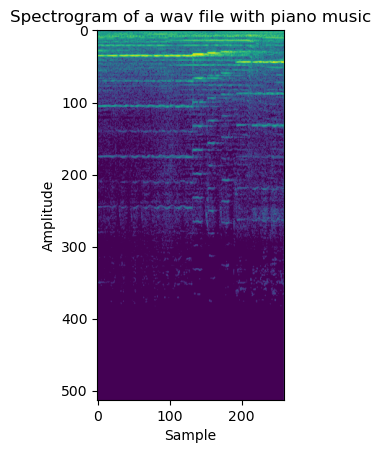

In [9]:
n_fft = 1024
hop_length = 512
f_min = 20
f_max = 8000
# sample_rate = 16000

def open_song(pat: Path):
    son = librosa.load(pat, sr=None) 
    return son

def song2img(son):
    clip, sample_rate = son
    clip = clip[:sample_rate*3]
    stft = librosa.stft(clip, n_fft=n_fft, hop_length=hop_length)
    stft_magnitude, _ = librosa.magphase(stft)
    stft_magnitude_db = librosa.amplitude_to_db(stft_magnitude)
    return stft_magnitude_db
    
song = open_song(song_path)
spec = song2img(song)
print(type(spec), spec.shape)
plot.title('Spectrogram of a wav file with piano music')
plot.imshow(spec)
plot.xlabel('Sample')
plot.ylabel('Amplitude')

In [134]:
def CustomSplitter(splitter):
    def my_splitter(paths: list[Path]):
        sPaths = {}
        for i, pat in enumerate(paths):
            sPat = re.sub(r'_+\d+$', '', pat.stem)
            if sPat not in sPaths:
                sPaths[sPat] = []
            sPaths[sPat].append(i)
        sPaths = list(sPaths.values())
        train, valid = splitter(sPaths)
        train = list(itertools.chain(*map(sPaths.__getitem__, train)))
        valid = list(itertools.chain(*map(sPaths.__getitem__, valid)))
        return train, valid
    return my_splitter

In [168]:
def tfm(pat: Path):
    return song2img(open_song(pat))

sdbl = DataBlock(
    blocks = [ImageBlock(), MultiCategoryBlock],
    get_items = get_song_files,
    item_tfms = tfm,
    splitter = CustomSplitter(RandomSplitter()),
    get_x = tfm,
    get_y = file_labels,
)

In [169]:
dls = sdbl.dataloaders(path)

In [170]:
print(len(dls.train.dataset))
print(len(dls.valid.dataset))
dls.train

5369
1336


['cel', 'cla', 'flu', 'gac', 'gel', 'org', 'pia', 'sax', 'tru', 'vio', 'voi']


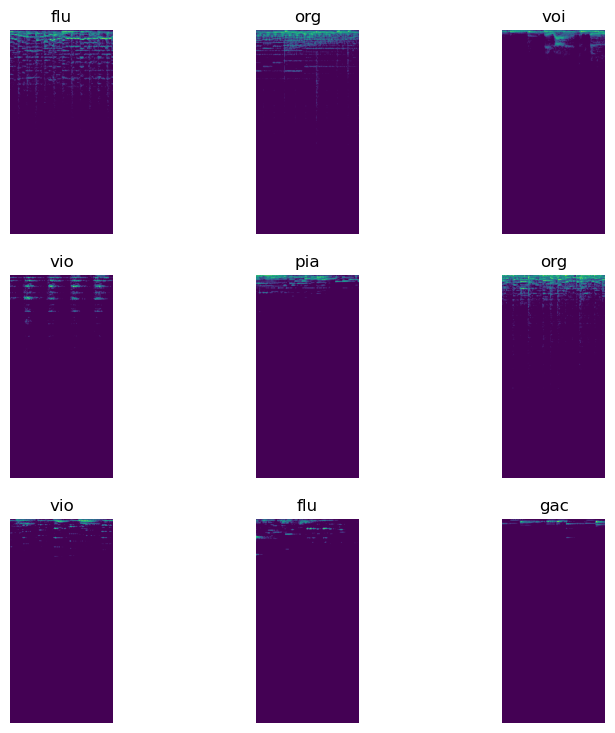

In [171]:
# sdbl.summary(path)
print(dls.vocab)
dls.train.show_batch()

In [172]:
learn = vision_learner(dls, resnet18, metrics=accuracy_multi)
learn.fine_tune(2)

C:\Users\Rango\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Rango\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.802633,0.446925,0.821584,02:12


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.399602,0.229595,0.922972,01:39
1,0.270826,0.197266,0.932022,01:37
